In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

## Загрузка и предобработка.

In [2]:
try:
    data = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Занятия с ментором\ML курс\ML-Course\data\podcasts.csv")
except:
    data = pd.read_csv(r"C:\Users\tzslapin\ML-Course\podcast\podcasts.csv")

In [3]:
data.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [5]:
data.isna().sum()

Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes         5246
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage    5258
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes         5395
dtype: int64

In [6]:
data.dropna(subset=['Listening_Time_minutes'], inplace=True)

In [7]:
data.duplicated().sum()

2237

In [8]:
data.drop_duplicates(inplace=True)

**Вывод по предобработке:**
- загрузили данные в которых порядка 50 тыс. объектов.
- всего 11 столбцов: 5 количественных, 6 -категориальных.
- Так как дубли не несут полезной информации для составления модели мы их удалили.
- Пропуски в тренировочных данных оставили, попробуем заменить их средним значением.
- Пропуски в целевом признаке удалены.

## Построим графики.

### Количественные признаки.

In [9]:
num_col = data.select_dtypes(include='number').columns.to_list()
cat_col = data.select_dtypes(exclude='number').columns.to_list()

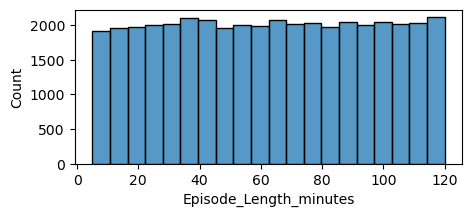

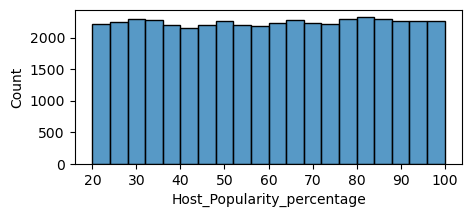

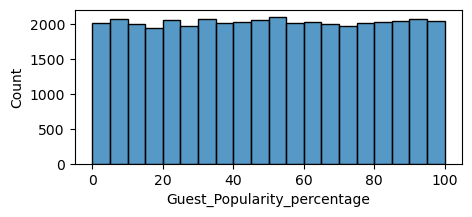

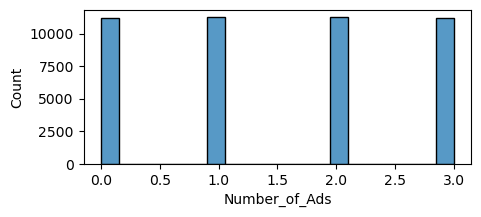

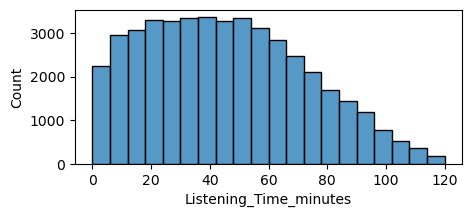

In [10]:
for i in range(len(num_col)):
    plt.figure(figsize=(5,2))
    sns.histplot(data=data, x=num_col[i], bins=20)

In [11]:
len(num_col)

5

Видно равномерное распределение всех числовых признаков кроме целевого. Целевой признак имеет тренд на снижение количества прослушиваний продолжительностью более 60 минут.

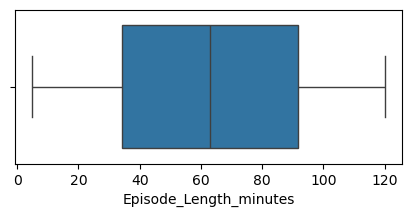

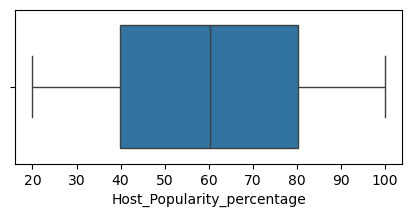

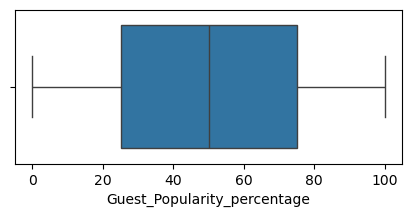

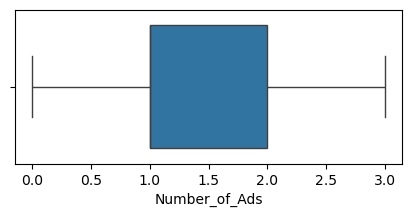

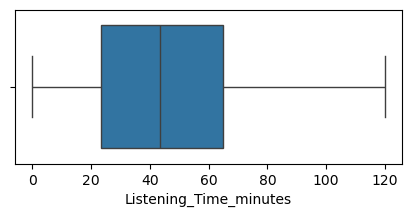

In [12]:
for i in range(len(num_col)):
    plt.figure(figsize=(5,2))
    sns.boxplot(data=data, x=num_col[i])

**Все значения расположены в диапазоне усов графика - выбросов не выявлено.**

посмотрим на зависимости целевой переменной от количественных признаков.

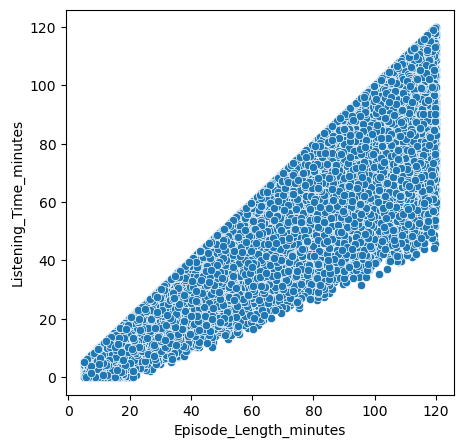

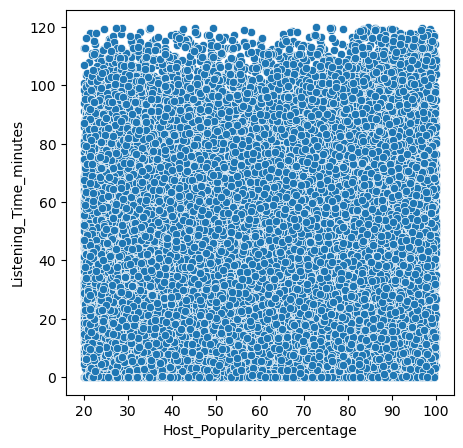

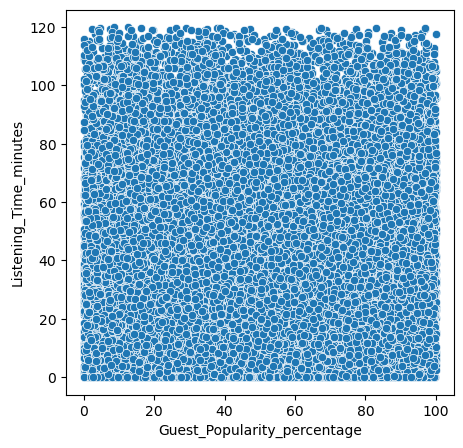

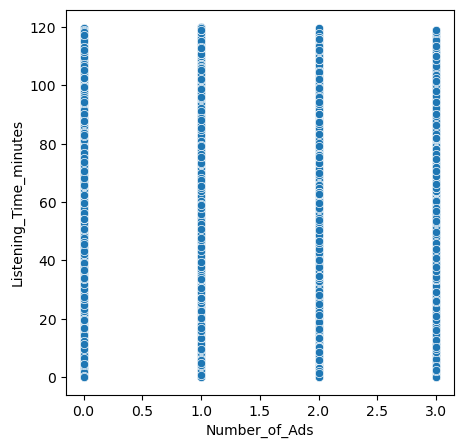

In [13]:
for i in range(len(num_col)-1):
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=data, x=num_col[i], y=num_col[-1])

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Episode_Length_minutes,40374.0,62.911157,33.140476,5.00,34.372500,62.995000,91.660000,120.00
Host_Popularity_percentage,44868.0,60.164403,23.150859,20.00,39.980000,60.320000,80.310000,100.00
Guest_Popularity_percentage,40394.0,50.097692,28.857913,0.01,25.140000,50.125000,75.110000,100.00
Number_of_Ads,44868.0,1.500334,1.116351,0.00,1.000000,1.000000,2.000000,3.00
Listening_Time_minutes,44868.0,45.541663,27.141247,0.00,23.330685,43.555075,64.917734,119.97


- Имеем 5 количественных признаков. Два признака выражены в процентах.
- `Number_of_Ads` относится к категориальному признаку.
- Линейных зависимостей между количественными признаками и целевым согласно графиков нет. Зависимость между общей продолжительностью и продолжительностью прослушивания не имеет обобщающей способности. Конечно общая продолжительность подкаста оказывает влияние на время прослушивания, но этот фактор не "подталкивает" к увеличению интереса или вовлеченности в подкаст и зависимость здесь другого плана.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Episode_Length_minutes'),
  Text(1.5, 0, 'Host_Popularity_percentage'),
  Text(2.5, 0, 'Guest_Popularity_percentage'),
  Text(3.5, 0, 'Number_of_Ads'),
  Text(4.5, 0, 'Listening_Time_minutes')])

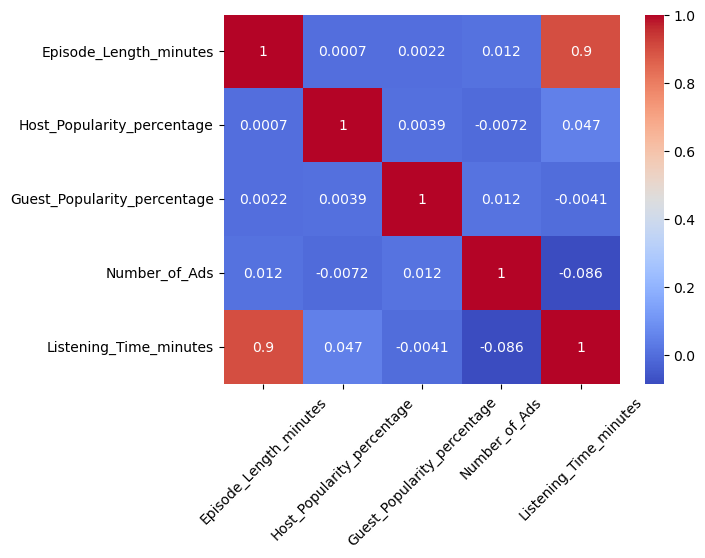

In [15]:
sns.heatmap(data[num_col].corr(), annot=True, cmap='coolwarm')
plt.xticks(rotation=45)

### Категориальные признаки.

In [16]:
cat_col

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

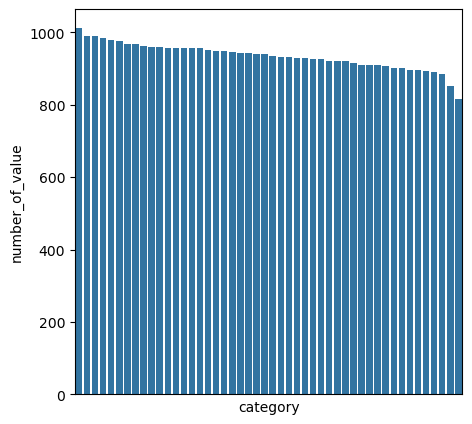

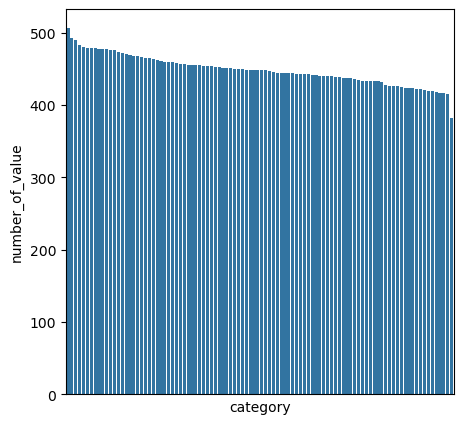

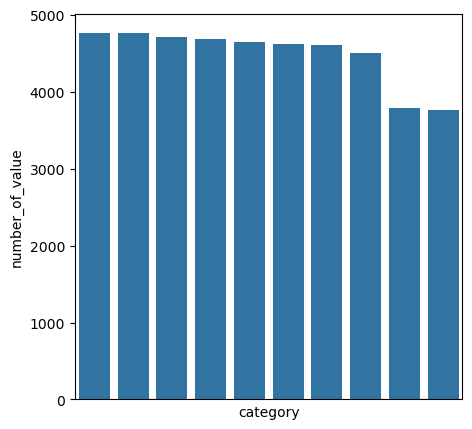

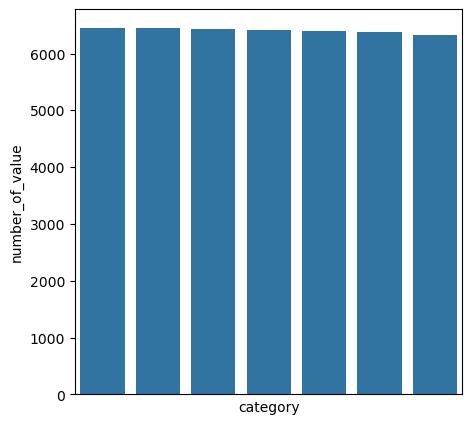

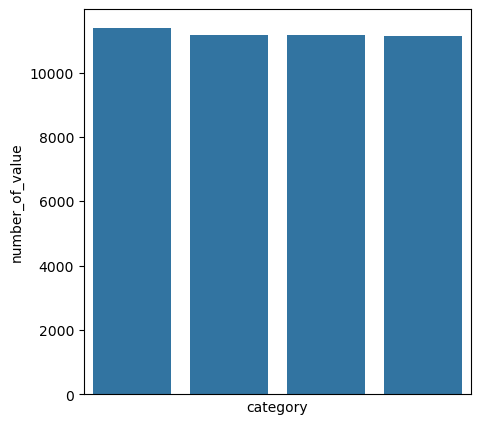

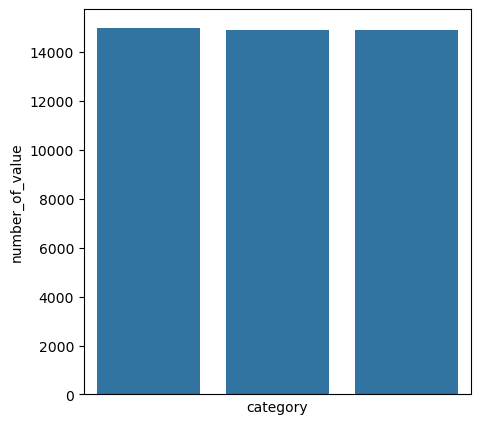

In [17]:
for i in range(len(cat_col)):
    data_value=data[cat_col[i]].value_counts().reset_index()
    data_value.columns=['category', 'number_of_value']

    plt.figure(figsize=(5,5))
    sns.barplot(data=data_value, y='number_of_value', x='category')
    plt.xticks([])

Категориальные признаки распределены равномерно.

## Построение модели через пайплайн.

Перенесём признак `Number_of_Ads` в разряд категориальных.

In [18]:
num_col.remove('Number_of_Ads')

In [19]:
num_col.remove('Listening_Time_minutes')

In [20]:
num_col

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage']

In [21]:
cat_col.append('Number_of_Ads')

In [22]:
features=data.drop('Listening_Time_minutes', axis=1)
target = data['Listening_Time_minutes']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True)

In [24]:
print(X_train.shape)
X_test.shape

(35894, 10)


(8974, 10)

Первая часть пайплайна - масштабирование `StandardScaler` и замена пропусков средним значением.

In [25]:
scaler_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='mean')),
         ('scaler', StandardScaler())
         ]
)

Вторая часть пайплайна - кодирование `OneHotEncoder`.

In [26]:
ohe_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('ohe', OneHotEncoder(drop='first'))
         ]
)

Объединим в пайплайн подготовки данных `data_preprocessor`

In [27]:
data_preprocessor = ColumnTransformer([
    ('scaler', scaler_pipe, num_col),
    ('ohe', ohe_pipe, cat_col)] ,
remainder = 'passthrough'
)

Составим итоговый пайплайн.

In [56]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

In [57]:
param_grid = [{
    'preprocessor__ohe': [OneHotEncoder(drop='first', sparse_output=False), TargetEncoder(), 'passthrough'], 
    
    'model': [LinearRegression()]
}]

In [36]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

In [40]:
grid_search.fit(X_train, y_train)

C:\Users\tzslapin\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tzslapin\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tzslapin\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tzslapin\AppData\Local\anaconda3\Lib\site-packages\sk

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Episode_Length_minutes',
                                                                          'Host_Popularity_percentage',
                                                                          'Guest_Popularity_percentage']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_...nt')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Podcast_Name',
                                                                          'Episode_Title',
                                                                          'Genre',
                                                                          'Publication_Day',
                                                                          'Publication_Time',
                                                                          'Episode_Sentiment',
                                                                          'Number_of_Ads'])])),
                                       ('model', LinearRegression())]),
             param_grid=[{'model': [LinearRegression()],
                          'preprocessor__ohe': [OneHotEncoder(drop='first',
                                                              sparse_output=False),
                                                TargetEncoder(),
                                                'passthrough']}],
             scoring='r2')

In [63]:
model = grid_search.best_estimator_

По итогам работы Grid Search построена модель линейной регрессии с TargetEncoder.

## Выбор и расчет метрики. 

Так как нет однозначного представления какие величины ошибок RMSE или МАЕ являются допустимыми для заказчика выберем метрику `R2`

In [43]:
r2_train = r2_score(model.predict(X_train), y_train)
r2_train

0.6570172266430542

In [44]:
r2_test = r2_score(model.predict(X_test), y_test)
r2_test

0.6424827430366205

- Показатель r2 модели составляет 0.64 на тесте.
- Это означает то, что в 64 % случаев предсказание модели будет ближе к истине чем среднее значение.

## Построение графика важности признаков. 

In [67]:
coef = model.named_steps['model'].coef_

In [72]:
coef

array([ 2.32085715e+01,  1.18263599e+00, -1.77097014e-01,  3.48199667e-02,
        2.29685468e-03,  4.68423452e-01, -4.61453263e-02,  1.96055455e-01,
        8.61553661e-01,  1.09636082e+00])

In [70]:
column = model.named_steps['preprocessor'].get_feature_names_out()
column

array(['scaler__Episode_Length_minutes',
       'scaler__Host_Popularity_percentage',
       'scaler__Guest_Popularity_percentage', 'ohe__Podcast_Name',
       'ohe__Episode_Title', 'ohe__Genre', 'ohe__Publication_Day',
       'ohe__Publication_Time', 'ohe__Episode_Sentiment',
       'ohe__Number_of_Ads'], dtype=object)

In [83]:
df_for_graph = pd.DataFrame({'coef': coef, 'feature' : column}).sort_values(by='coef', ascending=False)

C:\Users\tzslapin\AppData\Local\Temp\ipykernel_26796\719292198.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_for_graph, y='feature', x='coef',palette='viridis')


<Axes: xlabel='coef', ylabel='feature'>

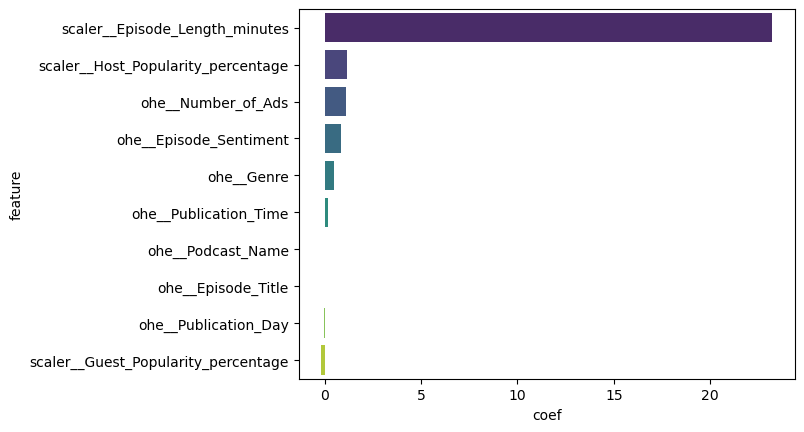

In [90]:
sns.barplot(data=df_for_graph, y='feature', x='coef',palette='viridis')

- Из графика видно, что самый сильный признак - общая продолжительность эпизода.
- Посмотрим на другие признаки.

In [85]:
df_for_graph_2 = pd.DataFrame({'coef': coef[1:], 'feature' : column[1:]}).sort_values(by='coef', ascending=False)

<Axes: xlabel='coef', ylabel='feature'>

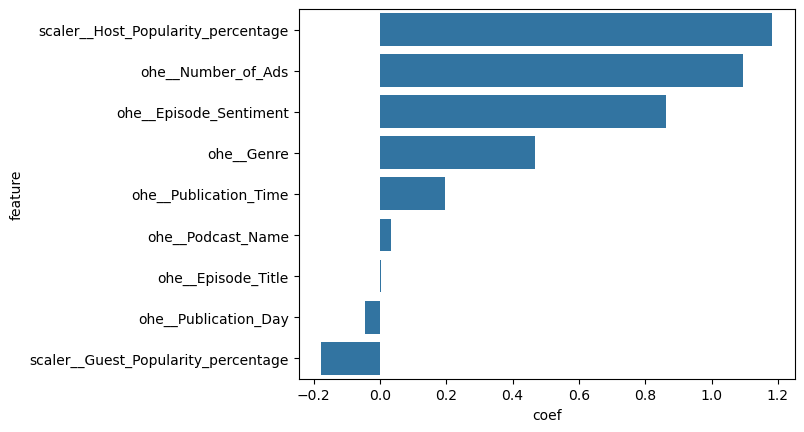

In [86]:
sns.barplot(data=df_for_graph_2, y='feature', x='coef')

**Выводы:**
 - второе, третье и четвертое место по важности занимают признаки Оценка популярности ведущего, количество рекламы и общая эмоциональная окраска контента эпизода
 - обратную зависимость на длительность прослушивания имеет Оценка популярности гостя эпизода.

**Рекомендация заказчику:**
1. Получение информации о длительности прослушивания от разработанной модели позволяет создателю подкастов оптимизировать затраты на размещение подкастов в онлайн ресурсах. Зная прогнозируемую длительность прослушивания можно укоротить фактическую длительность подкаста и не платить за лишние минуты онлайн платформе.
2. Прогнозируемая длительность прослушивания позволяет запланировать вставку рекламных роликов таким образом, чтобы у роликов было наибольшее число просмотров.
3. График важности признаков модели позволяет выявить паттерны для увеличения длительности прослушивания.